# Hyperparameter Evolution
La evolución de hiperparametros permite tener una IA más flexible, capaz de balancear distintos aspectos.


# 1.- Learning Rate
Existe un compromiso entre tener un learning rate alto para beneficiar la exploración pero con baja resolución para ser capaz de llegar a los minimos; o tener un learning rate muy bajo para tener mayor detalle pero haciendo el entrenamiento muy lento.

In [1]:
from sklearn.model_selection import train_test_split

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_, clip_grad_value_
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
from tqdm import tqdm_notebook
from shutil import copyfile
import os
import math
import pickle
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import PIL
from PIL import Image
from collections import Counter

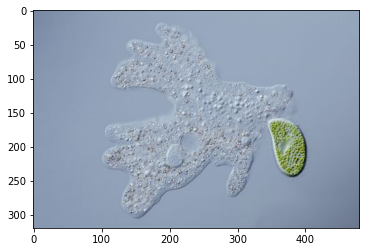

In [5]:
# data image folder
data_path = 'data/micro_org/'

# veamos la primera
img = plt.imread(data_path + 'Amoeba/Image_1.jpg')
plt.imshow(img);

In [6]:
# hyperparametros
epochs = 150
num_classes = 10
batch_size = 64
learning_rate = 0.001

In [7]:
dataset = torchvision.datasets.ImageFolder(
    data_path, 
    transform=transforms.Compose([
        transforms.Resize(size=(220,220)),
        transforms.ToTensor()
    ]))

loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size)

analisis y trabajo basico con tensores de información

In [8]:
dataset.class_to_idx

{'Amoeba': 0,
 'Euglena': 1,
 'Hydra': 2,
 'Paramecium': 3,
 'Rod_bacteria': 4,
 'Spherical_bacteria': 5,
 'Spiral_bacteria': 6,
 'Yeast': 7}

In [9]:
# el color y desviación estandar en los pixeles
N = len(loader.dataset)
mean = 0.
std = 0.

for images, _ in loader:
    batch_samples = images.size(0)
    # representa las imagenes como tensor
    # Dimension (batch, RGB: 3, 220 x 220)
    # el -1 hace que se acomode automaticamente el 220x220
    images = images.view(batch_samples, images.size(1), -1)

    # el promomedio y desviacion estandar de cada imagen
    # en la dimensión de index 2; osea los 220x220
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

# dividimos por el N
mean /= N
std /= N

print(f"promedio: {mean}")
print(f"std: {std}")

promedio: tensor([0.5290, 0.5465, 0.5402])
std: tensor([0.1656, 0.1671, 0.1678])


### Data Loaders
Proveeremos de aumento de datos para así tener mayor cantidad de estos;
nos referimos a aplicar rotaciones, crops, flips, etc..

In [10]:
train_dataset = torchvision.datasets.ImageFolder(
    data_path, 
    transform=transforms.Compose([
        transforms.Resize(size=(220,220)),
        transforms.RandomRotation(degrees=30),
        transforms.RandomCrop(160),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(hue=.1, saturation=.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]))

test_dataset = torchvision.datasets.ImageFolder(
    data_path, 
    transform=transforms.Compose([
        transforms.Resize(size=(160,160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]))

In [11]:
train_idx, valid_idx= train_test_split(
    np.arange(len(train_dataset)), test_size=0.2, 
    random_state=11, shuffle=True
    )

In [12]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [13]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, 
    sampler=train_sampler, drop_last=True
    )
    
valid_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, 
    sampler=valid_sampler
    )

In [14]:
dataloaders = {}
dataloaders["train"] = train_loader
dataloaders["val"] = valid_loader

Tengamos display de la información

In [15]:
from utiles import imshow # imshow para tensores

(1298, 1298, 3)


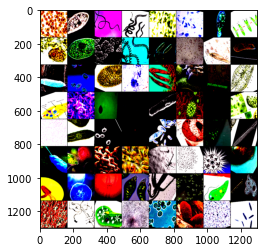

In [16]:
for data, classes in train_loader:
  out = torchvision.utils.make_grid(data)
  imshow(out, title=None)
  break

(1298, 1298, 3)


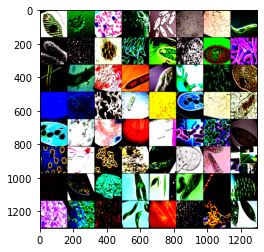

In [17]:
for data, classes in train_loader:
  out = torchvision.utils.make_grid(data)
  imshow(out, title=None)
  break